In [1]:
from netCDF4 import Dataset
import numpy as np
import pandas as pd
import xarray as xr
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime,date
import plotly.express as px
import myfunction as mf
#Define some lists/arrays
depth = np.array([0.02, 0.04, 0.06, 0.08,0.12,0.16,0.20,0.24,0.28,0.32,0.36,0.40,0.44,0.54,0.64,0.74,0.84,0.94,1.04,1.14,2.39,4.676,7.635,11.140,15.115])
node_z = [0.01,0.04,0.09,0.16,0.26,0.40,0.587,0.80,1.06,1.36,1.70,2.08,2.50,2.99,3.58,4.27,5.06,5.95,6.94,8.03,9.795,13.328,19.483,28.871,41.998]
sec_pr_day=60*60*24
depth_30=np.array([0.02,0.04,0.06,0.08,0.10]) #layer depths to multiply with concentrations
depth_50=np.array([0.02,0.04,0.06,0.08,0.12,0.16,0.02]) #[meters]

C_pool_names   =  ['LITm', 'LITs', 'SAPb', 'SAPf', 'EcM','AM', 'SOMp', 'SOMa', 'SOMc']
N_pool_names =  ['N_LITm', 'N_LITs', 'N_SAPb', 'N_SAPf', 'N_EcM', 'N_AM','N_SOMp', 'N_SOMa', 'N_SOMc', 'N_NH4_sol','N_NH4_sorp','N_NO3']

PFT_names=["not_vegetated                           ",
    "needleleaf_evergreen_temperate_tree     ",
    "needleleaf_evergreen_boreal_tree        ",
    "needleleaf_deciduous_boreal_tree        ",
    "broadleaf_evergreen_tropical_tree       ",
    "broadleaf_evergreen_temperate_tree      ",
    "broadleaf_deciduous_tropical_tree       ",
    "broadleaf_deciduous_temperate_tree      ",
    "broadleaf_deciduous_boreal_tree         ",
    "broadleaf_evergreen_shrub               ",
    "broadleaf_deciduous_temperate_shrub     ",
    "broadleaf_deciduous_boreal_shrub        ",
    "c3_arctic_grass                         ",
    "c3_non-arctic_grass                     ",
    "c4_grass                                ",]
PFT_names=[i.strip() for i in PFT_names]

temp_colors =["blue","purple","red"]
prec_colors = ["goldenrod","lightseagreen","darkblue"]

### Steps that define things

In [3]:
#COPY THIS TO NOTEBOOK, THE globals() THING DOES NOT WORK FROM HERE. 
def import_decomp(dir_list,file_ext,date_bool):
    site_data=[]
    decomp_names=[]
    dirs = dir_list
    path_of_the_directory = '/home/elisacw/soil_decomp/results/'

    for folder in dirs:
        ext = (folder+file_ext)
        for files in os.listdir(path_of_the_directory+folder):
            if files.endswith(ext):
                filename = os.fsdecode(files)  
                name = filename[:-len(ext)-1]
                if name[0:2] != 'NR':
                    name='NR'+name#+folder
                else:
                    name = name #+folder
                decomp_names.append(name)
                globals()[name+"_"+folder+file_ext[0:-3]] = xr.load_dataset(path_of_the_directory+folder+"/"+filename)

                globals()[name+"_"+folder+file_ext[0:-3]].attrs['site_name'] = name
                globals()[name+"_"+folder+file_ext[0:-3]].attrs['run_name'] = folder
                if date_bool:
                    mf.add_date_dim(globals()[name+"_"+folder+file_ext[0:-3]])

                site_data.append(globals()[name+"_"+folder+file_ext[0:-3]])
            else:
                continue
        site_data =  sorted(site_data,key=lambda x: x.site_name)
        decomp_names = sorted(decomp_names)
        #decomp_names: list of name strings
        #site_data: list of xarrays
    return decomp_names,site_data

In [4]:
def plot_depths_vr(data, pool_list,plot_title):

    fig = plt.figure(figsize=(25, 5*len(data.levsoi)))
    fig.suptitle(plot_title, fontsize=18, y=.90)
    for i in range(len(data.levsoi)):
        ax = fig.add_subplot(len(data.levsoi), 1, i+1)
        ax.set_title("Layer nr: %i" % i, fontsize=14)
        for p in range(len(pool_list)):
            pool_mass = data[pool_list[p]][i]*depth[i]
            plt.plot(data.time, pool_mass, label='%s' % pool_list[p])
            plt.legend()
            plt.grid(True)
# ///////////////////////////////////////////////////////////////////////////////////////////////////////////////////
# This one does not plot the total mass!


def plot_pools_vr(data, pool_list, plot_title):

    fig = plt.figure(figsize=(25, 5*len(pool_list)))
    fig.suptitle(plot_title, fontsize=18, y=.92)

    for p in range(len(pool_list)):
        ax = fig.add_subplot(len(pool_list), 1, p+1)
        ax.set_title(pool_list[p], fontsize=14)
        for i in range(len(data.levsoi)):
            pool_mass = data[pool_list[p]][i]*depth[i]
            plt.plot(data.time, pool_mass, label='Layer nr: %i' % (i+1))
            plt.legend()
            plt.grid(True)



In [5]:
def add_date_dim(data):  # data: xarray dataset

    to_int = data.mcdate.astype('int')

    to_str = to_int.astype('str')

    dates_list = [datetime.strptime(date, '%Y%m%d')
                  for date in list(to_str.values)]

    data.coords["time"] = dates_list

    return data

### Historical data

In [6]:
hist_ds = xr.load_dataset("/home/elisacw/soil_decomp/results/equal_input/langtjern_equal_input_to1992.nc")
add_date_dim(hist_ds)
hist_ds

<xarray.Dataset>
Dimensions:              (levsoi: 10, time: 1826, NoMMKeqs: 6, SAPpools: 2)
Coordinates:
  * time                 (time) datetime64[ns] 1988-02-01 ... 1993-01-01
Dimensions without coordinates: levsoi, NoMMKeqs, SAPpools
Data variables: (12/139)
    LITm                 (levsoi, time) float32 4.692e+03 4.692e+03 ... 107.7
    vert_changeLITm      (levsoi, time) float32 0.0 -0.03613 ... -8.246e-06
    N_LITm               (levsoi, time) float32 68.58 68.58 ... 2.502 2.502
    N_vert_changeLITm    (levsoi, time) float32 0.0 -0.0004995 ... -1.918e-07
    LITs                 (levsoi, time) float32 3.083e+04 3.083e+04 ... 321.6
    vert_changeLITs      (levsoi, time) float32 0.0 -0.1817 ... -1.55e-05
    ...                   ...
    desorp               float32 1.051e-06
    k_sapsom             (SAPpools) float32 5.601e-05 2.46e-05
    f_phys               (SAPpools) float32 0.3613 0.2242
    f_avail              (SAPpools) float32 0.5911 0.633
    f_chem               (SAPpools) float32 0.04759 0.1428
    depth                float32 1.52

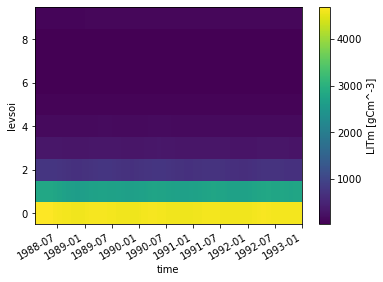

In [7]:
hist_ds["LITm"].plot()

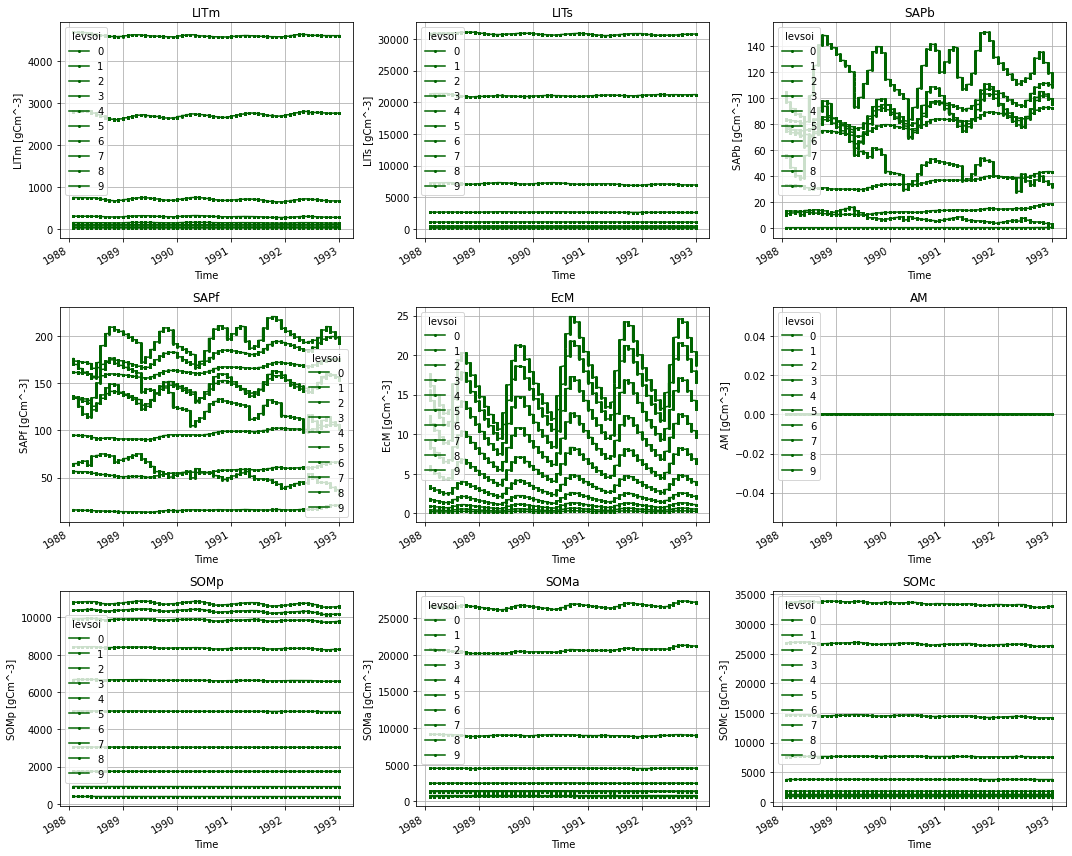

In [8]:
### Plotting of several variables in subplots ###

C_pool_names   =  ['LITm', 'LITs', 'SAPb', 'SAPf', 'EcM','AM', 'SOMp', 'SOMa', 'SOMc']

# Calculate the number of rows and columns for subplots based on the number of variables
num_variables = len(C_pool_names)
num_cols = 3  # Number of columns for subplots (adjust as needed)
num_rows = (num_variables + num_cols - 1) // num_cols

# Create subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 12))
fig.subplots_adjust(hspace=0.5)

# Customize line colors and marker size for each variable
line_colors = ['darkgreen'] # for different colors: ['g', 'r', 'c', 'm', 'y', 'k', '0.4', '0.6', '0.8', '0.2', '0.3', '0.7']
marker_size = 2  # Adjust the marker size as needed

# Iterate through each variable and create subplots
for i, variable_name in enumerate(C_pool_names):
    row = i // num_cols
    col = i % num_cols
    ax = axs[row, col]
    
    hist_ds[variable_name].plot.line(x='time', marker='o', linestyle='-', ax=ax, color=line_colors[i % len(line_colors)], markersize=marker_size)
    ax.set_xlabel('Time')
    #ax.set_ylabel(variable_name)
    ax.set_title(f'{variable_name}')
    ax.grid(True)

# Remove empty subplots
for i in range(num_variables, num_rows * num_cols):
    fig.delaxes(axs.flatten()[i])

plt.tight_layout()
plt.show()

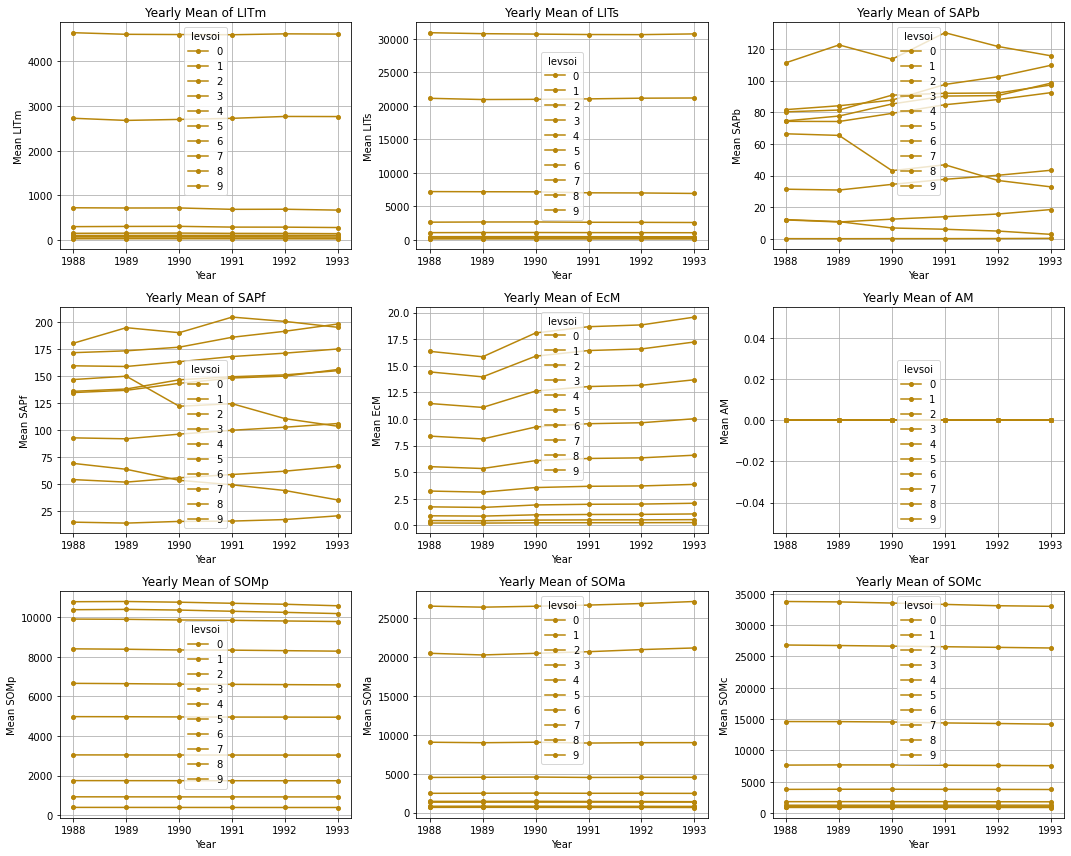

In [10]:
### Plotting the MEAN of several variables in subplots ###

# Calculate yearly means for each variable
yearly_means = {}
for variable_name in C_pool_names:
    yearly_means[variable_name] = hist_ds[variable_name].groupby('time.year').mean('time')

# Calculate the number of rows and columns for subplots based on the number of variables
num_variables = len(C_pool_names)
num_cols = 3  # Number of columns for subplots (adjust as needed)
num_rows = (num_variables + num_cols - 1) // num_cols

# Create subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 12))
fig.subplots_adjust(hspace=0.5)

# Customize line colors and marker size for each variable
line_colors = ["darkgoldenrod"] # for different colors: ['b', 'g', 'r', 'c', 'm', 'y', 'k', '0.4', '0.6', '0.8', '0.2', '0.3', '0.7', '0.9', '0.1']
marker_size = 4  # Adjust the marker size as needed

# Iterate through each variable and create subplots for yearly means
for i, variable_name in enumerate(C_pool_names):
    row = i // num_cols
    col = i % num_cols
    ax = axs[row, col]
    
    yearly_means[variable_name].plot.line(x='year', marker='o', linestyle='-', ax=ax, color=line_colors[i % len(line_colors)], markersize=marker_size)
    ax.set_xlabel('Year')
    ax.set_ylabel(f'Mean {variable_name}')
    ax.set_title(f'Yearly Mean of {variable_name}')
    ax.grid(True)

# Remove empty subplots
for i in range(num_variables, num_rows * num_cols):
    fig.delaxes(axs.flatten()[i])

plt.tight_layout()
plt.show()


NameError: name 'num_soil_layers' is not defined

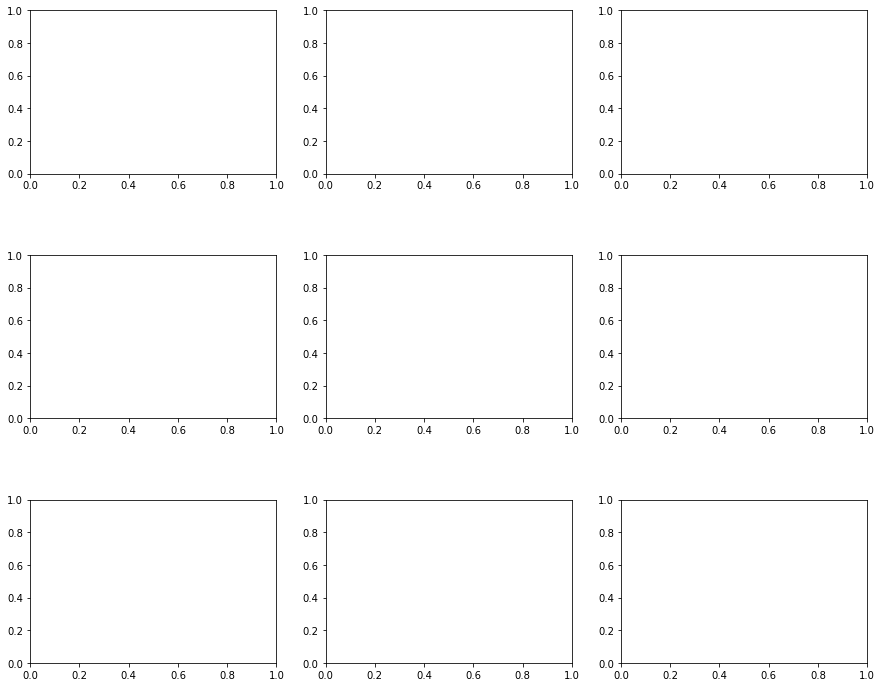

ELINS stuff

In [17]:
def plot_seasonal_mass_and_conc_carbon(data, title):
    month_length = data.time.dt.days_in_month
    weights = (month_length.groupby("time.season") /
               month_length.groupby("time.season").sum())
    weighted_season_mean = (
        weights*data).groupby("time.season").sum(dim="time")

    # Use to convert from gC/m3 to gC/m2
    active_depths = xr.DataArray(depth[:len(data.levsoi)], dims="levsoi")
    weighted_season_mean_mass = weighted_season_mean*active_depths

    fig = plt.figure(figsize=[20, 30])
    fig.suptitle("Mass of C, "+title, y=0.92, fontsize="x-large")
    for n, ticker in enumerate(C_pool_names):
        ax = plt.subplot(5, 3, n + 1)
        ax.invert_yaxis()
        plt.xlabel("[gC/m2]")
        plt.ylabel("Depth [m]")
        plt.grid()
        for i in range(4):
            ax.plot(weighted_season_mean_mass[C_pool_names[n]][i, :], node_z[0:len(weighted_season_mean_mass.levsoi)], 
                    '-*', label="%s" % (weighted_season_mean.season[i].values))
            ax.set_title("%s" % (C_pool_names[n]))
            ax.legend()

    fig = plt.figure(figsize=[20, 30])
    fig.suptitle("Concentration of C, "+title, y=0.92, fontsize="x-large")
    for n, ticker in enumerate(C_pool_names):
        ax = plt.subplot(5, 3, n + 1)
        ax.invert_yaxis()
        plt.xlabel("[gC/m3]")
        plt.ylabel(" [m]")
        plt.grid()
        for i in range(4):
            ax.plot(weighted_season_mean[C_pool_names[n]][i, :], node_z[0:len(weighted_season_mean.levsoi)],
                 '-*', label="%s" % (weighted_season_mean.season[i].values))
            ax.set_title("%s" % (C_pool_names[n]))
            ax.legend()


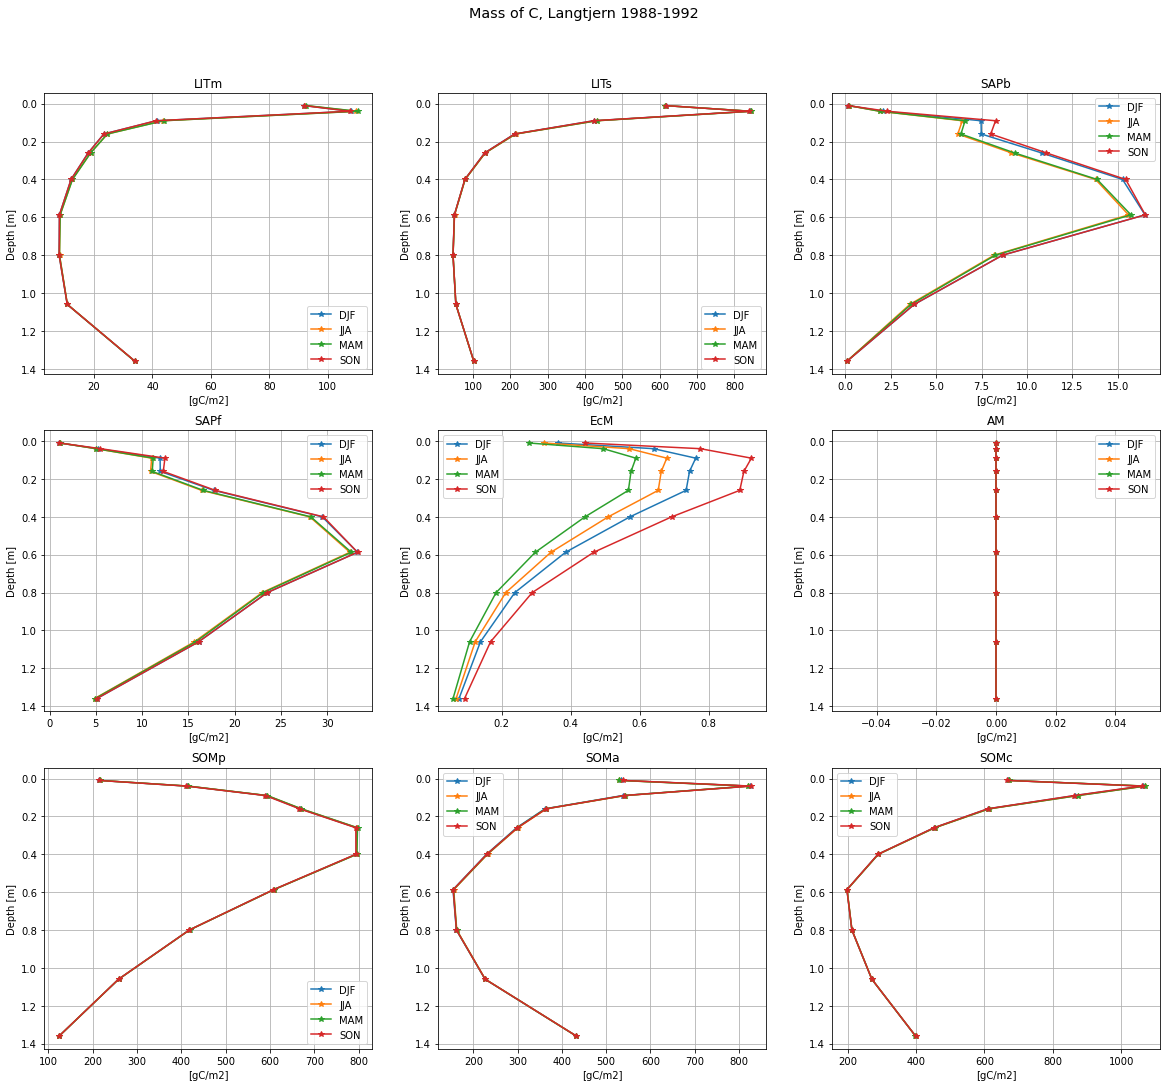

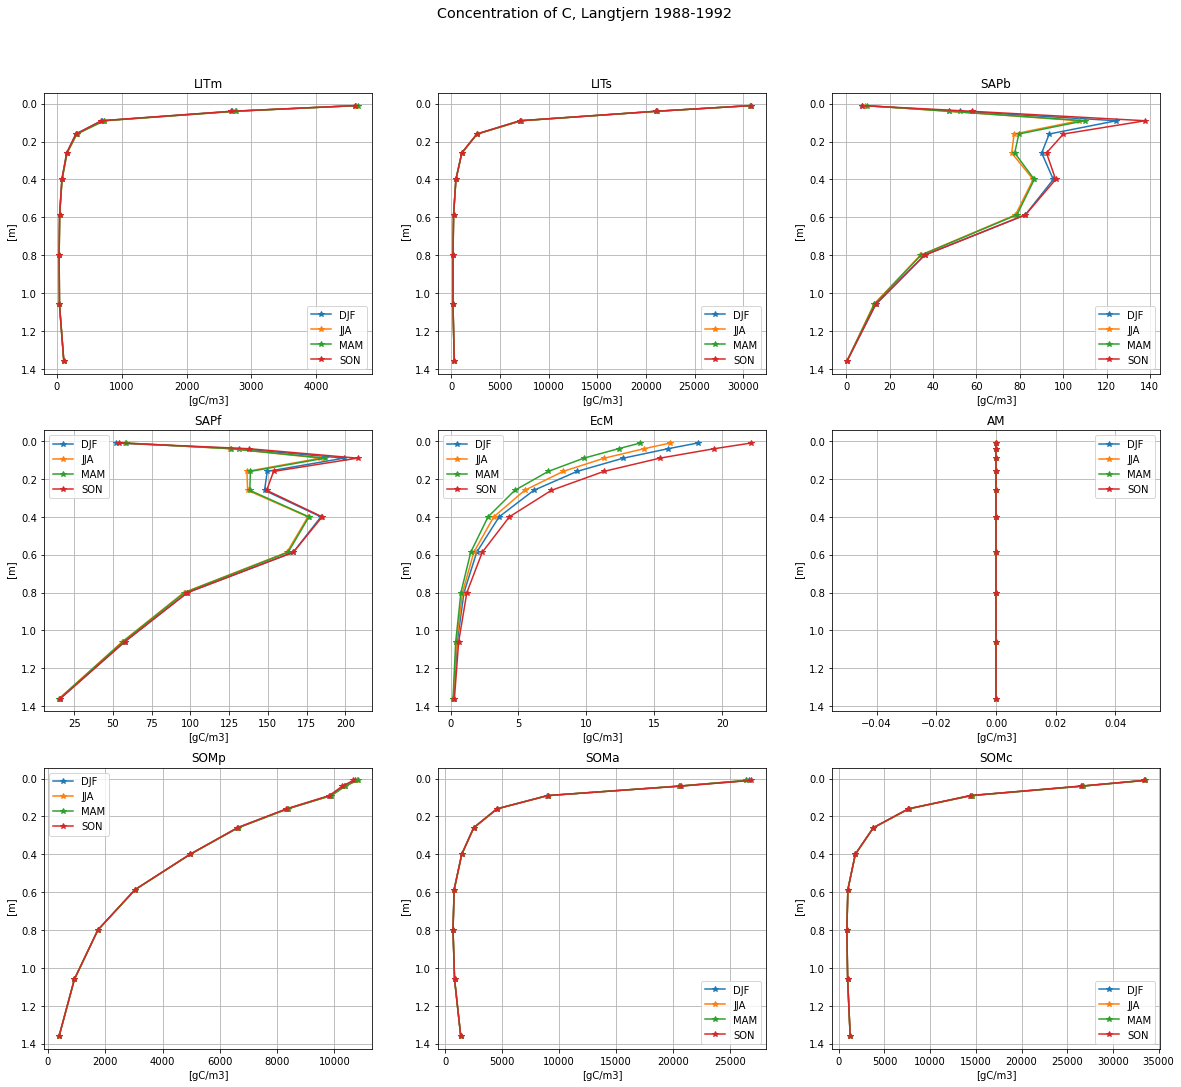

In [18]:
plot_seasonal_mass_and_conc_carbon(hist_ds,"Langtjern 1988-1992")

In [11]:
hist_ds = xr.load_dataset("/home/elisacw/soil_decomp/results/equal_input/langtjern_equal_input_to1970.nc")
add_date_dim(hist_ds)
hist_ds

<xarray.Dataset>
Dimensions:              (levsoi: 10, time: 7, NoMMKeqs: 6, SAPpools: 2)
Coordinates:
  * time                 (time) datetime64[ns] 1900-02-01 ... 1961-09-01
Dimensions without coordinates: levsoi, NoMMKeqs, SAPpools
Data variables: (12/139)
    LITm                 (levsoi, time) float32 4.636e+03 4.655e+03 ... 83.9
    vert_changeLITm      (levsoi, time) float32 0.0 -0.03303 ... -4.736e-06
    N_LITm               (levsoi, time) float32 67.76 68.07 ... 1.745 1.949
    N_vert_changeLITm    (levsoi, time) float32 0.0 -0.000454 ... -1.098e-07
    LITs                 (levsoi, time) float32 3.023e+04 2.983e+04 ... 267.7
    vert_changeLITs      (levsoi, time) float32 0.0 -0.1621 ... -8.023e-06
    ...                   ...
    desorp               float32 1.051e-06
    k_sapsom             (SAPpools) float32 5.601e-05 2.46e-05
    f_phys               (SAPpools) float32 0.3613 0.2242
    f_avail              (SAPpools) float32 0.5911 0.633
    f_chem               (SAPpools) float32 0.04759 0.1428
    depth                float32 1.52

In [20]:
def plot_seasonal_mass_and_conc_carbon(data, title):
    month_length = data.time.dt.days_in_month
    weights = (month_length.groupby("time.season") /
               month_length.groupby("time.season").sum())
    weighted_season_mean = (
        weights*data).groupby("time.season").sum(dim="time")

    # Use to convert from gC/m3 to gC/m2
    active_depths = xr.DataArray(depth[:len(data.levsoi)], dims="levsoi")
    weighted_season_mean_mass = weighted_season_mean*active_depths

    fig = plt.figure(figsize=[20, 30])
    fig.suptitle("Mass of C, "+title, y=0.92, fontsize="x-large")
    for n, ticker in enumerate(C_pool_names):
        ax = plt.subplot(5, 3, n + 1)
        ax.invert_yaxis()
        plt.xlabel("[gC/m2]")
        plt.ylabel("Depth [m]")
        plt.grid()
        for i in range(4):
            ax.plot(weighted_season_mean_mass[C_pool_names[n]][i, :], node_z[0:len(weighted_season_mean_mass.levsoi)], 
                    '-*', label="%s" % (weighted_season_mean.season[i].values))
            ax.set_title("%s" % (C_pool_names[n]))
            ax.legend()

    fig = plt.figure(figsize=[20, 30])
    fig.suptitle("Concentration of C, "+title, y=0.92, fontsize="x-large")
    for n, ticker in enumerate(C_pool_names):
        ax = plt.subplot(5, 3, n + 1)
        ax.invert_yaxis()
        plt.xlabel("[gC/m3]")
        plt.ylabel(" [m]")
        plt.grid()
        for i in range(4):
            ax.plot(weighted_season_mean[C_pool_names[n]][i, :], node_z[0:len(weighted_season_mean.levsoi)],
                 '-*', label="%s" % (weighted_season_mean.season[i].values))
            ax.set_title("%s" % (C_pool_names[n]))
            ax.legend()


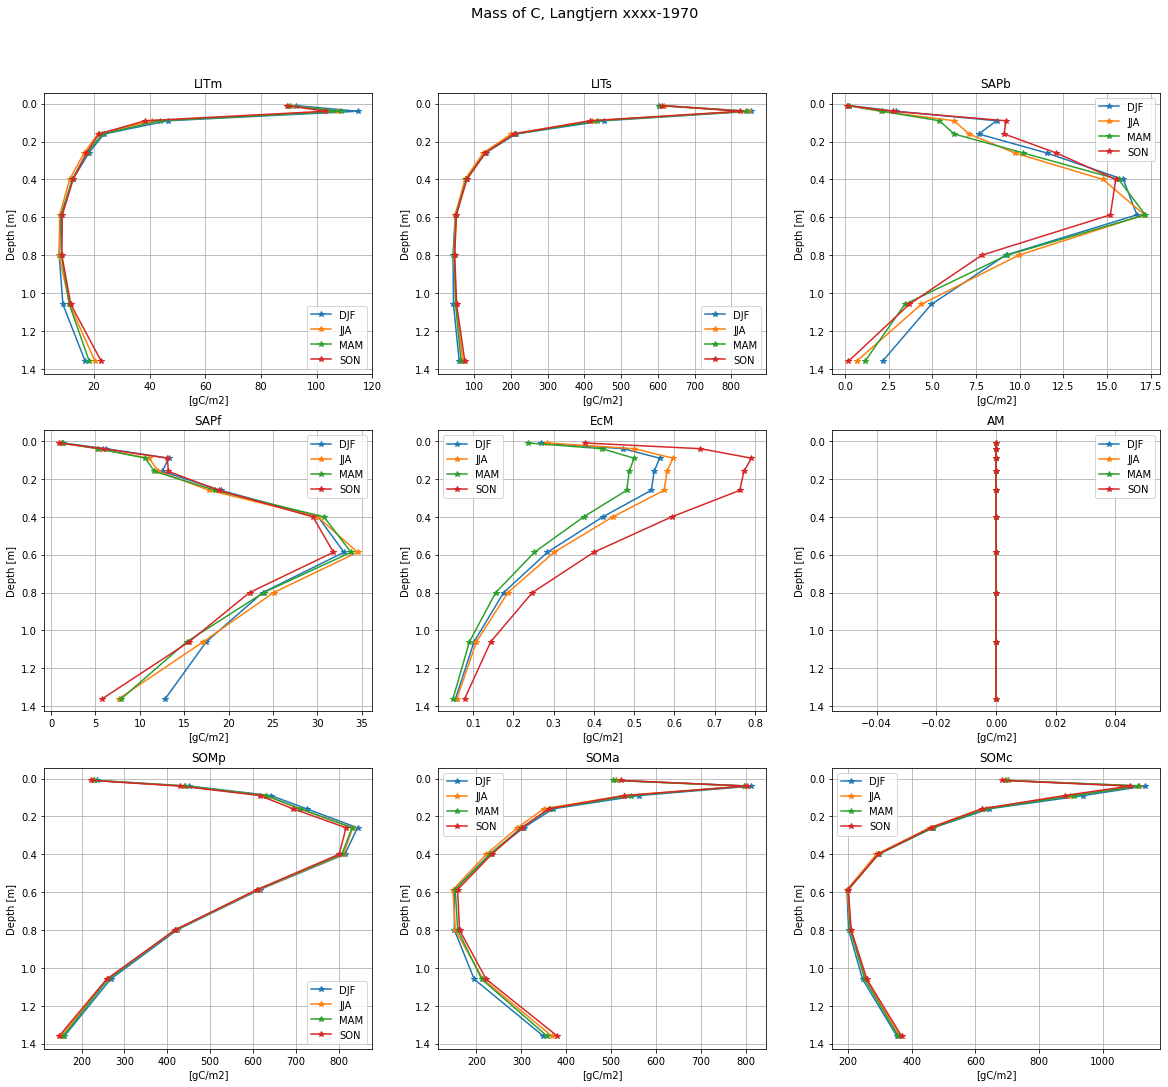

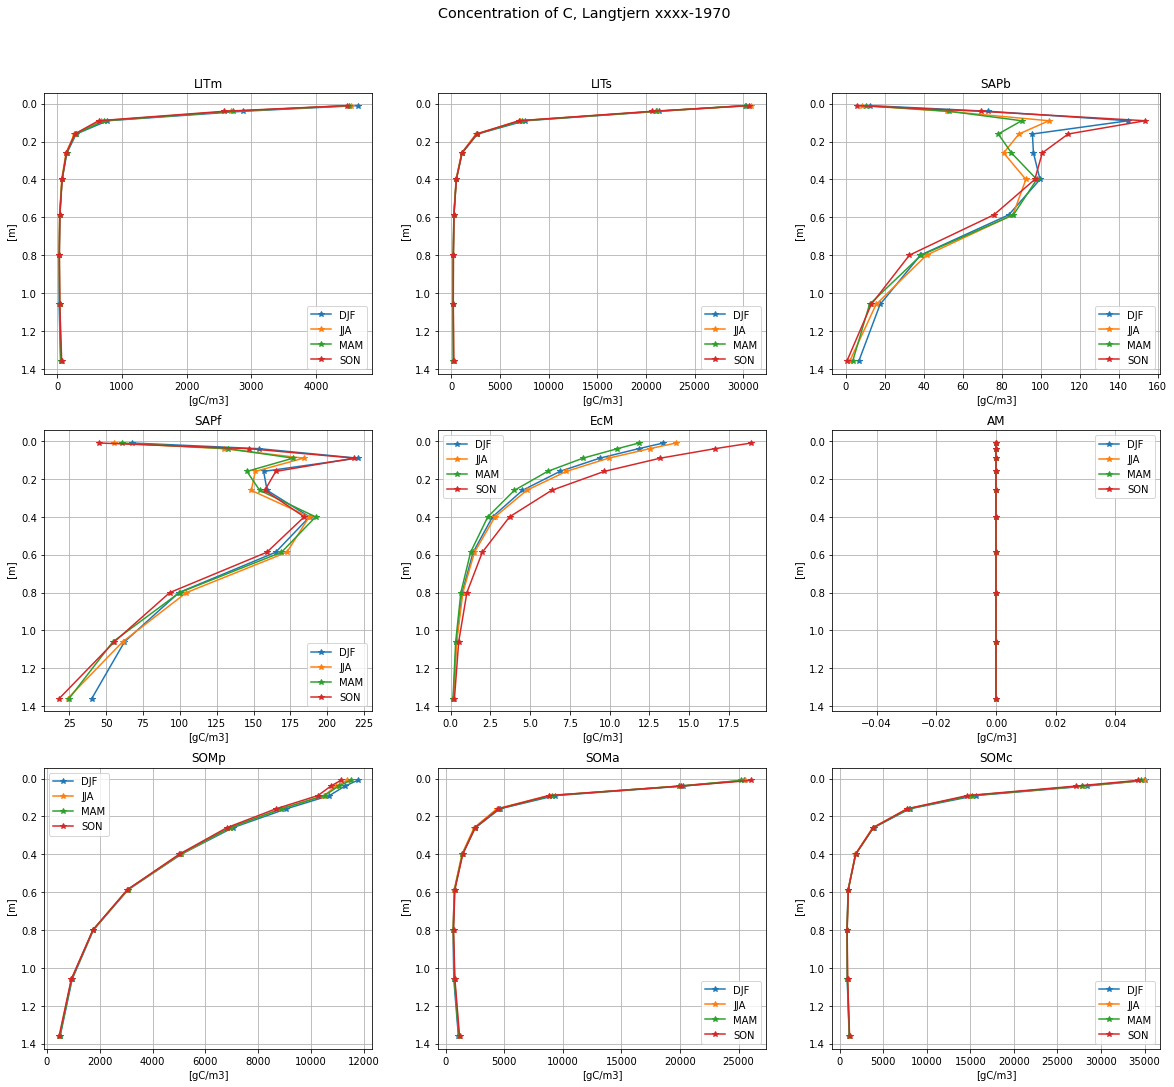

In [21]:
plot_seasonal_mass_and_conc_carbon(hist_ds,"Langtjern xxxx-1970")